# Original Version

## 1. Web Crawling for Stock Related News

In [ ]:
!pip install selenium
!pip install vaderSentiment

In [1]:
#import the library
import requests
from bs4 import BeautifulSoup
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk import sent_tokenize
import pandas as pd
from pandas_datareader import data as web
import datetime
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys  
from selenium.webdriver.chrome.options import Options
import time
import numpy as np
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys  
from selenium.webdriver.chrome.options import Options

import time

def scrolling_down_page(stock_name):
    #Using chromedriver to open the web
    url = "https://finance.yahoo.com/quote/"+ str(stock_name) +"/?p=" + str(stock_name)
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    driver = webdriver.Chrome(executable_path='/Users/lovemicky/Downloads/chromedriver',chrome_options=chrome_options)
    driver.get(url)
    time.sleep(3) 
    
    #Selenium automates browsers, scrolling down the page until contents are fully updated
    from selenium.webdriver import ActionChains
    for i in range(10): 
        ActionChains(driver).key_down(Keys.DOWN).perform() 
        print(f'have finished {i} times')
        time.sleep(1)
    
    #Acquire page source code
    html_ = driver.page_source.encode('utf-8')
    results_page = BeautifulSoup(html_,'lxml')
    
    return results_page

In [3]:
def get_article_link(results_page):
    all_links = []
    try:
        # we find the href contains in the tag_h3
        all_h3_tags = results_page.find_all('h3', {'class': "Mb(5px)"})
        article_link = []
        # try to find the href in the tag_h3
        for tag in all_h3_tags:
            try:
                article_link.append(tag.find('a').get('href'))
            except:
                return None
        for link in article_link:
            if 'http' in link:
                all_links.append(link)
            else:
                home_url = 'https://finance.yahoo.com'
                url = home_url + link
                all_links.append(url)
        return all_links
    except:
        return None

In [4]:
def get_article_content(all_links):
    article_content = []
    try:
        for link in all_links:
            if link[:26] != 'https://finance.yahoo.com/':
                continue
            contents = []
            response = requests.get(link)
            if not response.status_code == 200:
                return None
            result_page = BeautifulSoup(response.content,'lxml')
            time_tag = result_page.find('time')
            time = time_tag.get_text()
            contents.append(time)
            try:
                content_tag = result_page.find_all('p',{'class':'canvas-atom canvas-text Mb(1.0em) Mb(0)--sm Mt(0.8em)--sm'})
                for content in content_tag:
                    article = content.get_text()
                    contents.append(article)
            except:
                return None
            article_content.append(contents)  
        return article_content
    except:
        return article_content

In [5]:
stock_name = 'AAPL'
results_page = scrolling_down_page(stock_name)
all_links=get_article_link(results_page)
artical_content=get_article_content(all_links)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':


have finished 0 times
have finished 1 times
have finished 2 times
have finished 3 times
have finished 4 times
have finished 5 times
have finished 6 times
have finished 7 times
have finished 8 times
have finished 9 times


## 2. Text Mining

In [6]:
#change artical content format for text mining
def artical_format(artical_content):
    artical_texts = []
    for i in artical_content:
        if len(i)>1:
            artical_texts.append([i[0]]+[''.join(i[1:])])
    return artical_texts

In [7]:
#return text analysis results
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk import sent_tokenize
import pandas as pd
def vader_comparison(texts):
    headers = ['Name','pos','neg','neu','compound']
    result=pd.DataFrame(columns=headers)
    print("Name\t",'  pos\t','neg\t','neu\t','compound')
    analyzer = SentimentIntensityAnalyzer()
    for i in range(len(texts)):
        name = texts[i][0]
        sentences = sent_tokenize(texts[i][1])
        pos=compound=neu=neg=0
        for sentence in sentences:
            vs = analyzer.polarity_scores(sentence)
            pos+=vs['pos']/(len(sentences))
            neu+=vs['neu']/(len(sentences))
            neg+=vs['neg']/(len(sentences))
            compound+=vs['compound']/(len(sentences))
        result=result.append(pd.DataFrame([[name,pos,neg,neu,compound]],columns=headers))
        print('%-10s'%name,'%1.2f\t'%pos,'%1.2f\t'%neg,'%1.2f\t'%neu,'%1.2f\t'%compound)
    result=result.sort_values(by='Name')
    result.index=range(len(result))
    return result

In [8]:
artical_texts=artical_format(artical_content)
news_result=vader_comparison(artical_texts)

Name	   pos	 neg	 neu	 compound
December 3, 2018 0.11	 0.07	 0.82	 0.09	
December 2, 2018 0.14	 0.07	 0.79	 0.31	
November 30, 2018 0.11	 0.02	 0.87	 0.26	
December 2, 2018 0.06	 0.02	 0.92	 0.12	
December 1, 2018 0.06	 0.11	 0.82	 -0.17	


## 3. Acquire Stock Data

In [11]:
def _get_djia_return():
    djia = requests.get('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
    soup = BeautifulSoup(djia.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    codes = []
    for row in table.findAll('tr')[1:]:
        code = row.findAll('td')[2].text
        codes.append(code[:-1])
    return codes
    
def _get_sp500_codes():
    sp500 = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = BeautifulSoup(sp500.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    codes = []
    for row in table.findAll('tr')[1:]:
        code = row.findAll('td')[0].text
        codes.append(code)
    return codes
        
def _get_nasdaq100_codes():
    nasdaq = requests.get('https://en.wikipedia.org/wiki/NASDAQ-100')
    soup = BeautifulSoup(nasdaq.text, 'lxml')
    table = soup.find('div', class_='div-col columns column-width')
    codes = []
    pattern = r'\(([A-Z]+)\)'
    for row in table.findAll('li'):
        a = re.findall(pattern, str(row.text))
        codes.append(a[0][:-1])
    return codes
    
def get_stock_return(universe_condition):
    start=datetime.datetime.today() - datetime.timedelta(4)
    end=datetime.datetime.today()
    ret_all = []
    if universe_condition == 'DJIA':
        codes = _get_djia_return()
    elif universe_condition == 'S&P500':
        codes = _get_sp500_codes()
    elif universe_condition == 'nasdaq100':
        codes = _get_nasdaq100_codes()
    for i in codes:
        df = web.DataReader(i, 'yahoo', start, end)
        ret = df['Close'].pct_change()[-1]
        ret_all.append(ret)
    return ret_all, codes

In [12]:
stock_return, stock_codes = get_stock_return('DJIA')

## 4. Data Virtualization

In [13]:
from pandas_datareader import data as web
from datetime import datetime
import math
def stock_analysis(start, end, stock_name):
    print(start,end)
    stock_df = web.DataReader(stock_name, 'yahoo', start, end)
    stock_df['logReturn']=pd.Series([math.log(i) for i in stock_df['Close']/stock_df['Open']],
                                 index=stock_df.index)
    stock_df.describe() #Get summary statistics
    return stock_df

In [14]:
stock_name = 'AAPL'
start=datetime(2000, 1, 1)
end=datetime.today()
stock_data=stock_analysis(start, end, stock_name)
stock_data

2000-01-01 00:00:00 2018-12-02 21:58:51.581807


,High,Low,Open,Close,Volume,Adj Close,logReturn
Date,,,,,,,
2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,2.677157,0.065172
2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,2.451444,-0.054581
2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,2.487319,0.002407
2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.272070,-0.110741
2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,2.379695,0.030615
2000-01-10,3.651786,3.383929,3.642857,3.491071,126266000.0,2.337840,-0.042560
2000-01-11,3.549107,3.232143,3.426339,3.312500,110387200.0,2.218258,-0.033789
2000-01-12,3.410714,3.089286,3.392857,3.113839,244017200.0,2.085222,-0.085816
2000-01-13,3.526786,3.303571,3.374439,3.455357,258171200.0,2.313924,0.023697


In [15]:
from datetime import datetime
def news_stock_analysis(news_result, stock_data):
    headers = ['Name','pos','neg','neu','compound']
    news_result=news_result.groupby(['Name'])[headers[1:]].mean()
    news_result['Date']=[str(datetime.strptime(i,'%B %d, %Y'))[:10] for i in news_result.index]
    news_result.index=range(len(news_result))
    
    stock_data['Date']=[str(i)[:10] for i in stock_data.index]
    stock_data.index=range(len(stock_data))
    
    compound_data=news_result.merge(stock_data, on='Date', how='left')
    return compound_data

In [16]:
c=news_stock_analysis(news_result, stock_data)

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates
def compare_plot(c, data1, data2):
    df=pd.DataFrame({'Date':matplotlib.dates.datestr2num(c['Date']),
                     'news_compound':np.array(c[data1]),
                     'stock_logReturn':np.array(c[data2])})
    plt.plot('Date','news_compound',data=df,marker='', color='olive', linewidth=2)
    plt.plot('Date','stock_logReturn',data=df,marker='', color='blue', linewidth=2, linestyle='dashed')
    plt.legend()

## 5. Prediciton

In [18]:
def get_sentiment(stock_code):
    sentiment_com_tr = []
    sentiment_pos_tr = []
    sentiment_neg_tr = []
    sentiment_com_te = []
    sentiment_pos_te = []
    sentiment_neg_te = []
    for i in stock_code:
        results_page = scrolling_down_page(i)
        all_links = get_article_link(results_page)
        artical_content = get_article_content(all_links)
        texts = artical_format(artical_content)
        a = vader_comparison(texts)
        a['Name'] = pd.to_datetime(a['Name'])
        a = a.sort_values(['Name'],ascending = 0)
        a_train = a[-round(len(a)*0.7):]
        a_test = a[:round(len(a)*0.3)]
        sentiment_com_tr.append(a_train.mean()['compound'])
        sentiment_pos_tr.append(a_train.mean()['pos'])
        sentiment_neg_tr.append(a_train.mean()['neg'])
        sentiment_com_te.append(a_test.mean()['compound'])
        sentiment_pos_te.append(a_test.mean()['pos'])
        sentiment_neg_te.append(a_test.mean()['neg'])
    sentiment =  [sentiment_com_tr,sentiment_pos_tr,sentiment_neg_tr,sentiment_com_te,sentiment_pos_te,sentiment_neg_te]
    return sentiment

In [19]:
sentiment = get_sentiment(stock_codes)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':


have finished 0 times
have finished 1 times
have finished 2 times
have finished 3 times
have finished 4 times
have finished 5 times
have finished 6 times
have finished 7 times
have finished 8 times
have finished 9 times
Name	   pos	 neg	 neu	 compound
December 1, 2018 0.10	 0.06	 0.83	 0.16	
November 30, 2018 0.12	 0.07	 0.81	 0.15	
November 29, 2018 0.09	 0.08	 0.83	 0.11	
November 30, 2018 0.22	 0.00	 0.78	 0.77	
November 30, 2018 0.22	 0.00	 0.78	 0.77	
have finished 0 times
have finished 1 times
have finished 2 times
have finished 3 times
have finished 4 times
have finished 5 times
have finished 6 times
have finished 7 times
have finished 8 times
have finished 9 times
Name	   pos	 neg	 neu	 compound
November 30, 2018 0.26	 0.00	 0.74	 0.65	
November 30, 2018 0.08	 0.02	 0.90	 0.35	
November 30, 2018 0.13	 0.02	 0.85	 0.34	
November 29, 2018 0.12	 0.10	 0.78	 0.14	
November 29, 2018 0.11	 0.00	 0.89	 0.40	
November 29, 2018 0.16	 0.01	 0.83	 0.47	
have finished 0 times
have finished

have finished 7 times
have finished 8 times
have finished 9 times
Name	   pos	 neg	 neu	 compound
November 30, 2018 0.22	 0.00	 0.78	 0.77	
November 30, 2018 0.22	 0.00	 0.78	 0.77	
November 30, 2018 0.08	 0.03	 0.89	 0.17	
November 30, 2018 0.10	 0.04	 0.85	 0.19	
November 30, 2018 0.10	 0.03	 0.86	 0.26	
November 30, 2018 0.11	 0.02	 0.87	 0.24	
November 29, 2018 0.11	 0.01	 0.89	 0.40	
have finished 0 times
have finished 1 times
have finished 2 times
have finished 3 times
have finished 4 times
have finished 5 times
have finished 6 times
have finished 7 times
have finished 8 times
have finished 9 times
Name	   pos	 neg	 neu	 compound
November 30, 2018 0.11	 0.01	 0.88	 0.39	
November 30, 2018 0.08	 0.03	 0.89	 0.17	
November 30, 2018 0.13	 0.02	 0.85	 0.37	
November 30, 2018 0.13	 0.02	 0.85	 0.34	
November 30, 2018 0.10	 0.01	 0.89	 0.40	
November 30, 2018 0.12	 0.03	 0.86	 0.30	
November 30, 2018 0.12	 0.05	 0.83	 0.26	
November 29, 2018 0.13	 0.02	 0.85	 0.42	
have finished 0 time

In [20]:
import matplotlib.pyplot as plt
def plot_scatter(sentiment, stock_return):
    plt.scatter(sentiment[0],stock_return, marker='x', color='m', s=30)
    plt.scatter(sentiment[1],stock_return, marker='o', color='r', s=20)
    plt.scatter(sentiment[2],stock_return, marker='^', color='g', s=30)

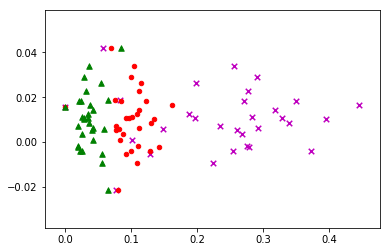

In [21]:
plot_scatter(sentiment, stock_return)

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def plot_3D_scatter(sentiment, stock_return):
    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')
    color_list=['r','b','g']
    marker_list=['o','^','+']
    z_list=list(range(1,4))
    for i in range(3):
        x=sentiment[i]
        y=stock_return
        z=[z_list[i]]*len(x)
        ax.scatter(x,y,z,c=color_list[i],marker=marker_list[i])
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Stock Return')
    plt.show()

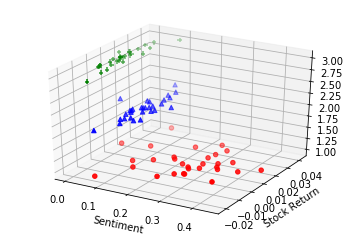

In [23]:
plot_3D_scatter(sentiment, stock_return)

In [24]:
from sklearn import linear_model
import numpy as np
def reg_scatter_plot(sentiment, stock_return):
    
    f, (ax1, ax2, ax3)=plt.subplots(3, sharex=False, sharey=True)
    
    regr1=regr2=regr3=linear_model.LinearRegression()
    regr1.fit(np.array(sentiment[0]).reshape(-1,1),np.array(stock_return).reshape(-1,1))
    ax1.scatter(sentiment[0], stock_return, s=30,c='r',marker='+',label='Sample')
    ax1.plot(sorted(sentiment[0]),regr1.predict(np.array(stock_return).reshape(-1,1)),color='black',linewidth=2)
    
    regr2.fit(np.array(sentiment[1]).reshape(-1,1),np.array(stock_return).reshape(-1,1))
    ax2.scatter(sentiment[1], stock_return, s=20,c='b',marker='o',label='Sample')
    ax2.plot(sorted(sentiment[1]),regr2.predict(np.array(stock_return).reshape(-1,1)),color='black',linewidth=2)
    
    regr3.fit(np.array(sentiment[2]).reshape(-1,1),np.array(stock_return).reshape(-1,1))
    ax3.scatter(sentiment[2], stock_return, s=30,c='g',marker='^',label='Sample')
    ax3.plot(sorted(sentiment[2]),regr3.predict(np.array(stock_return).reshape(-1,1)),color='black',linewidth=2)
    
    
    f.subplots_adjust(hspace=0.5)
    plt.xlabel('Sentiment')
    plt.ylabel('Stock Return')
    plt.show()

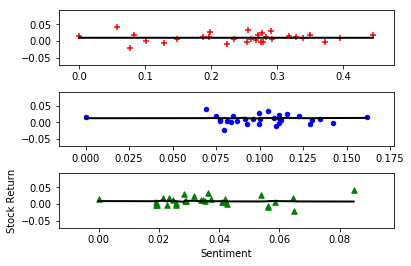

In [25]:
reg_scatter_plot(sentiment, stock_return)

In [29]:
def regress(sentiment):
    X = np.column_stack((sentiment[0], sentiment[1], sentiment[2]))
    X = sm.add_constant(X)
    X = np.nan_to_num(X)
    y = stock_return
    model = sm.OLS(y,X)
    OLS_results = model.fit()
    return OLS_results

In [30]:
OLS_result = regress(sentiment)

In [37]:
def prediction(stock_code, OLS_result):
    if isinstance(stock_code, str):
        stock_code = [stock_code] 
        predict_result_all = []
    for i in range(len(stock_code)):
        predict_return = np.dot([1, sentiment[3][i],sentiment[4][i],sentiment[5][i]],OLS_result.params)
        print('Predicted return for stock ', stock_code, ' is ', predict_return)
        predict_result_all.append(predict_return)
    return predict_result_all

In [38]:
stock_code = 'AAPL'
predict_result = prediction(stock_code, OLS_result)

Predicted return for stock  ['AAPL']  is  0.00736804055049


## 6. Main

In [ ]:
if __name__ == "__main__":
    #Web Crawling for Stock Related News
    stock_name = 'AAPL'
    results_page = scrolling_down_page(stock_name)
    all_links=get_article_link(results_page)
    artical_content=get_article_content(all_links)
    
    #Text Mining
    artical_texts=artical_format(artical_content)
    news_result=vader_comparison(artical_texts)
    
    #Acquire Stock Data
    stock_return, stock_codes = get_stock_return('DJIA')
    
    #Data Virtualization
    sentiment = get_sentiment(stock_codes)
    plot_scatter(sentiment, stock_return)
    plot_3D_scatter(sentiment, stock_return)
    reg_scatter_plot(sentiment, stock_return)
    
    #Prediction
    OLS_result = regress(sentiment)
    stock_code = 'AAPL'
    predict_result = prediction(stock_code, OLS_result)